# Exploring Customer Hotel Reservation Behavior
Alice He(xh2012), Yumeng Yan(yy3558), Haiqi Zeng(hz2330)

## Import libraries needed for this project

In [1]:
#!pip install seaborn
#!pip install scipy
#!pip install statsmodels
#!pip install scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

## Data Collection

### The data used in this project is from kaggle (https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset?resource=download). 

In [2]:
## read the data from csv file
df = pd.read_csv('hotel.csv')
df

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,8,3,Online,0,0,0,167.80,1,Not_Canceled
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,10,17,Online,0,0,0,90.95,2,Canceled
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,7,1,Online,0,0,0,98.39,2,Not_Canceled
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,4,21,Online,0,0,0,94.50,0,Canceled


## Data Cleaning

In [3]:
## see whether there are missing data
df.loc[np.sum(df.isna(),axis = 1)>0,:]

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status


#### Insights:
- As we can see above, our dataset has no missing values, so there is no need to deal with NAN values.

In [4]:
## rename the columns: shorten the names of some columns, such as required_car_parking_space = parking; room_type_reserved = room_type; etc.
column_rename_map = {
    'no_of_weekend_nights': 'weekend_nights',
    'no_of_week_nights': 'week_nights',
    'type_of_meal_plan': 'meal_plan',
    'required_car_parking_space': 'parking',
    'room_type_reserved': 'room_type',
    'market_segment_type':'market',
    'no_of_previous_cancellations':'prev_cancellations',
    'no_of_previous_bookings_not_canceled': 'prev_bookings',
    'avg_price_per_room': 'avg_price',
    'no_of_special_requests': 'special_requests'
}
df = df.rename(columns=column_rename_map)
df.head()

,Booking_ID,no_of_adults,no_of_children,weekend_nights,week_nights,meal_plan,parking,room_type,lead_time,arrival_year,arrival_month,arrival_date,market,repeated_guest,prev_cancellations,prev_bookings,avg_price,special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


#### Convert categorical data using dummy variables

In [5]:
# meal_plan column
#df['meal_plan'].unique()
mealplan_dict = {
    'Not Selected': 0,
    'Meal Plan 1': 1,
    'Meal Plan 2': 2,
    'Meal Plan 3': 3
}
df['meal'] = df['meal_plan'].map(lambda x: mealplan_dict[x])

In [6]:
# room_type column
#df['room_type'].unique()
room_map = {
    'Room_Type 1': 1,
    'Room_Type 2': 2,
    'Room_Type 3': 3,
    'Room_Type 4': 4,
    'Room_Type 5': 5,
    'Room_Type 6': 6,
    'Room_Type 7': 7
}
df['room'] = df['room_type'].map(lambda x: room_map[x])

In [7]:
# market column
#df['market'].unique()
market_map = {
    'Offline': 0,
    'Online': 1,
    'Corporate': 2,
    'Aviation': 3,
    'Complementary': 4
}
df['mkt'] = df['market'].map(lambda x: market_map[x])

In [8]:
# booking status column (for ANOVA test 1 below)
booking_map = {
    'Not_Canceled': 0,
    'Canceled': 1
}
df['cancel'] = df['booking_status'].map(lambda x: booking_map[x])

In [9]:
# no_of_children column (for ANOVA test 2 below)
child_map = {
    0: 0,
    1: 1,
    2: 1,
    3: 1,
    9: 1,
    10: 1
}
df['bring_child'] = df['no_of_children'].map(lambda x: child_map[x])

In [10]:
# create a season column based on the value of arrival_month column (spring: 1; summer: 2; fall: 3; winter: 4)
def map_season(month):
    if month >= 3 and month <= 5:
        return 1
    elif month >= 6 and month <= 8:
        return 2
    elif month >= 9 and month <= 11:
        return 3
    elif month == 12 or month <= 2:
        return 4
    else:
        return 'error'
df['season'] = df['arrival_month'].apply(map_season)

### Take a look at the dataset after improving:

In [11]:
df

,Booking_ID,no_of_adults,no_of_children,weekend_nights,week_nights,meal_plan,parking,room_type,lead_time,arrival_year,...,prev_bookings,avg_price,special_requests,booking_status,meal,room,mkt,cancel,bring_child,season
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,...,0,65.00,0,Not_Canceled,1,1,0,0,0,3
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,...,0,106.68,1,Not_Canceled,0,1,1,0,0,3
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,...,0,60.00,0,Canceled,1,1,1,1,0,4
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,...,0,100.00,0,Canceled,1,1,1,1,0,1
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,...,0,94.50,0,Canceled,0,1,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36270,INN36271,3,0,2,6,Meal Plan 1,0,Room_Type 4,85,2018,...,0,167.80,1,Not_Canceled,1,4,1,0,0,2
36271,INN36272,2,0,1,3,Meal Plan 1,0,Room_Type 1,228,2018,...,0,90.95,2,Canceled,1,1,1,1,0,3
36272,INN36273,2,0,2,6,Meal Plan 1,0,Room_Type 1,148,2018,...,0,98.39,2,Not_Canceled,1,1,1,0,0,2
36273,INN36274,2,0,0,3,Not Selected,0,Room_Type 1,63,2018,...,0,94.50,0,Canceled,0,1,1,1,0,1


### Now, let's take a look at the categorical and discrete data column by column.

In [12]:
# examine whether there is abnormal value in number of adults (e.g. it is abnormal to have 1.5 in the dataset)
df['no_of_adults'].unique()

array([2, 1, 3, 0, 4], dtype=int64)

<AxesSubplot:title={'center':'Countplot of Number of Adults'}, xlabel='no_of_adults', ylabel='count'>

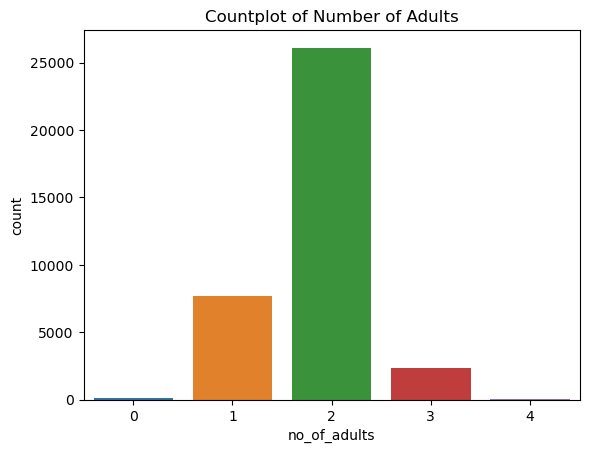

In [13]:
# number of adults
plt.title('Countplot of Number of Adults')
sns.countplot(data = df,x = 'no_of_adults')

#### Insights:
- There isn't abnormal value in this column.
- Most of the reservations are for two adults together, the second most are for one single adult, and the third are for 3 adults. There are very few booking for 0 adult or 4 adults.
- Most of the needs are for a couple or two adults travelling together, so the hotel should set most rooms as those can accommodate two adults, such as one king/queen bed or a twin room.
- There are certain need for 3 adults or 1 adult in a room. It would be better for the hotel to have those correlated room types.

In [14]:
# examine whether there is abnormal value in number of children (e.g. it is abnormal to have 1.5 in the dataset)
df['no_of_children'].unique()

array([ 0,  2,  1,  3, 10,  9], dtype=int64)

<AxesSubplot:title={'center':'Countplot of Number of children'}, xlabel='no_of_children', ylabel='count'>

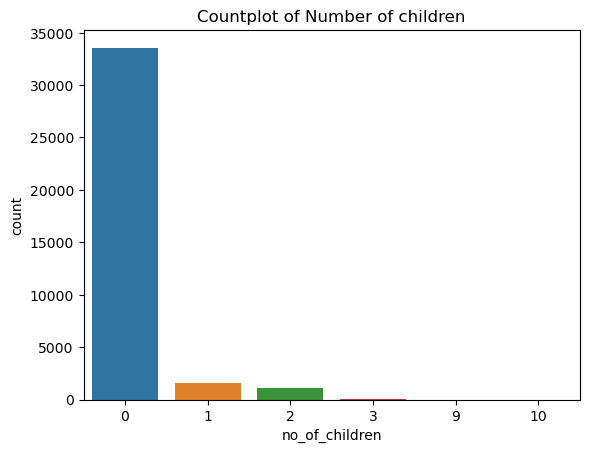

In [15]:
# number of children
plt.title('Countplot of Number of children')
sns.countplot(data = df,x = 'no_of_children')

#### Insights:
- There isn't abnormal value in this column; for those who bring 9 and 10 children, we infer that the booking could be for school trip groups.
- Most people are with no children, but there are some adults with 1 or more children.
- As a result, the hotel can consider provide a small number of family suites or some supplies for children if needed.

In [16]:
# examine whether there is abnormal value in number of weekend_nights (e.g. it is abnormal to have 1.5 in the dataset)
df['weekend_nights'].unique()

array([1, 2, 0, 4, 3, 6, 5, 7], dtype=int64)

<AxesSubplot:title={'center':'Countplot of Number of Weekend Nights'}, xlabel='weekend_nights', ylabel='count'>

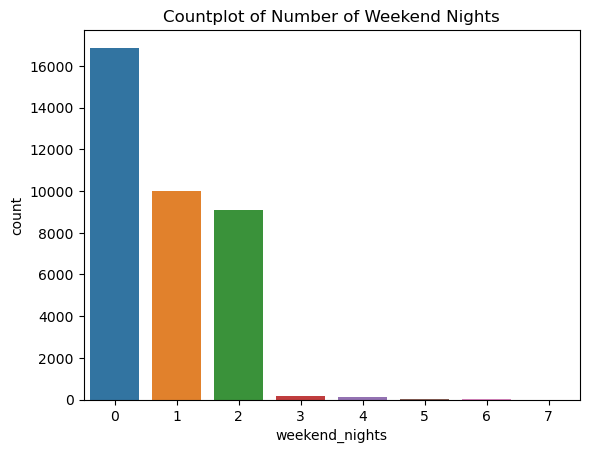

In [17]:
# number of weekend nights
plt.title('Countplot of Number of Weekend Nights')
sns.countplot(data = df,x = 'weekend_nights')

#### Insights:
- There isn't abnormal value in this column.
- Most people stay 0 weekend nights, which means they stay less than a week and during the weekday. The second and third most people stay 1 or 2 weekend nights. Very few people stat 3,4,5,6,7 weekend nights, suggesting an overall stay of over 2 weeks.
- In our dataset, majority stays within weekdays and less than 2 weeks. The hotel can highly expect new customers after 2 weeks and therefore set a more proper schedule for cleaning.

In [18]:
# examine whether there is abnormal value in number of week nights (e.g. it is abnormal to have 1.5 in the dataset)
df['week_nights'].unique()

array([ 2,  3,  1,  4,  5,  0, 10,  6, 11,  7, 15,  9, 13,  8, 14, 12, 17,
       16], dtype=int64)

<AxesSubplot:title={'center':'Countplot of Number of Week Nights'}, xlabel='week_nights', ylabel='count'>

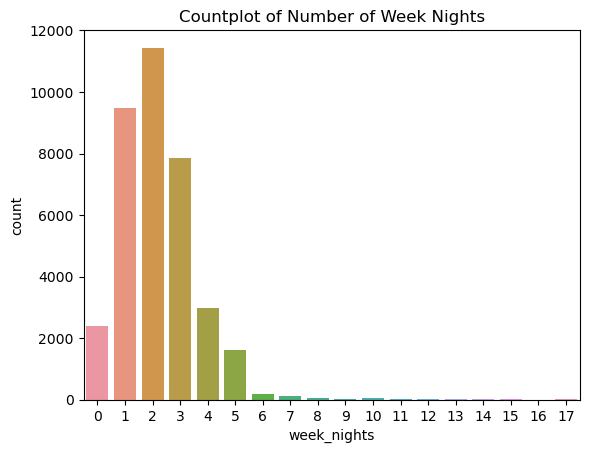

In [19]:
# number of week nights
plt.title('Countplot of Number of Week Nights')
sns.countplot(data = df,x = 'week_nights')

#### Insights:
- Number of weekdays reserved ranges from 0 to 17. Most of the reservations are 0 to 5 week nights, indicating a stay within a week. In this range, the top choice is two weekdays.
- The result allies with the analysis above about the number of weekend nights and specifies the most frequent time range of stay to one week. As a result, the hotel can highly expect new customers after 1 week and therefore set a more proper schedule for cleaning and new reservations.

<AxesSubplot:title={'center':'Countplot of Types of Meal Plan'}, xlabel='meal_plan', ylabel='count'>

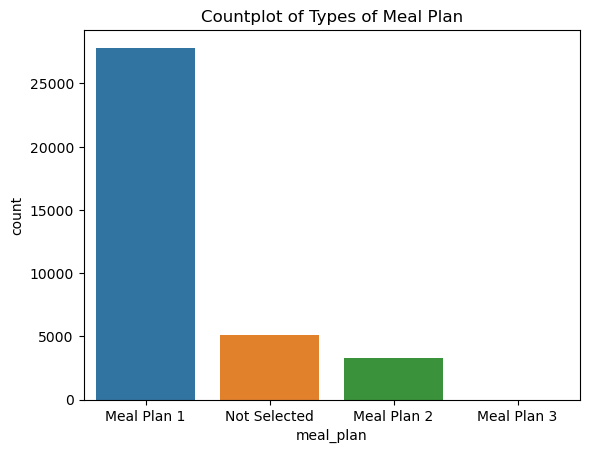

In [20]:
# meal_type
plt.title('Countplot of Types of Meal Plan')
sns.countplot(data = df,x = 'meal_plan')

#### Insights:
- There are 4 unique values for the meal_plan column, among them most customers chose Meal Plan 1 and least people chose Meal Plan 3. 
- In terms of operation efficiency, the hotel can adjust the relevant inventory level for each meal plan according to the frequency shown on the chart above. 

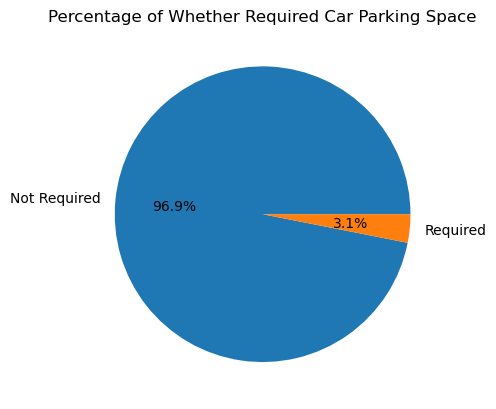

In [21]:
# parking
parking_pc = df['parking'].value_counts(normalize=True)*100
plt.pie(parking_pc, labels=['Not Required','Required'], autopct='%1.1f%%')
plt.title('Percentage of Whether Required Car Parking Space')
plt.show()

#### Insights:
- As shown on the chart above, the parking column is binary (0 for no, 1 for yes), and the most of customers did not request for a parking space. There isn't abnormal value in this column as there are only 2 possible values and the column is supposed to be binary.
- This indicates that the hotel can potential create more revenues by renting the some of the vacant parking space to outsiders other than customers to increase revenue per squared meter. 

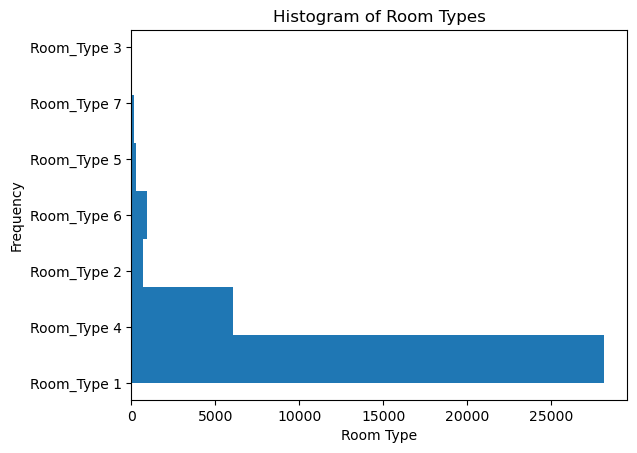

In [22]:
# room_type
plt.hist(df['room_type'], bins=7, orientation = 'horizontal') 
plt.title('Histogram of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Frequency')
plt.show()

#### Insights:
- As shown in the chart above, the room_type column can take 7 different values. The majority of customers chose Room Type 1; some customers chose Room Type 4; and least people has chosen Room Type 3, which makes sense as in a typical hotel some room types (e.g. double) are chosen more often than others (e.g. penthouse suite). (The values of room types are ciphered (encoded) by INN Hotels, so we cannot know which type they refer to directly.)

<AxesSubplot:title={'center':'Countplot of Arrival Year'}, xlabel='arrival_year', ylabel='count'>

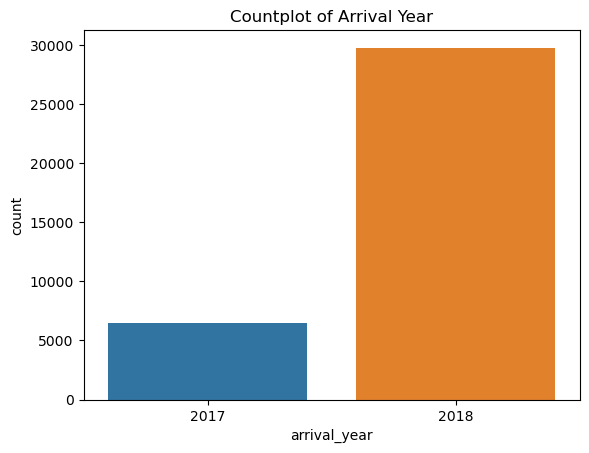

In [23]:
# arrival_year
plt.title('Countplot of Arrival Year')
sns.countplot(data = df,x = 'arrival_year')

#### Insights:
- The chart above shows bookings based on arrival year. It shows that our dataset covers booking infomation from 2017 to 2018. And, most of the records in this dataset are from 2018. 

<AxesSubplot:title={'center':'Countplot of Arrival Month'}, xlabel='arrival_month', ylabel='count'>

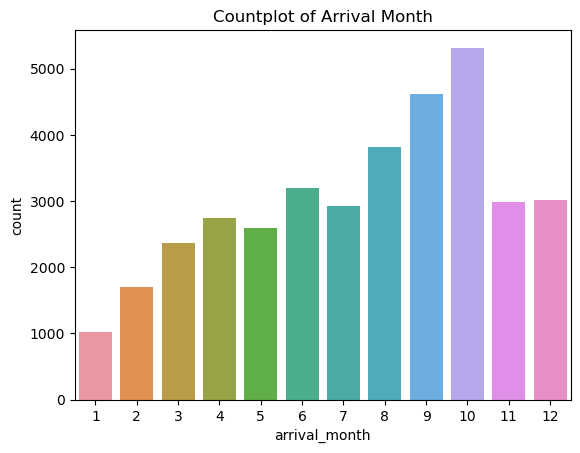

In [24]:
# arrival_month
plt.title('Countplot of Arrival Month')
sns.countplot(data = df,x = 'arrival_month')

#### Insights:
- The chart above shows the records of booking by arrival months. There isn't abnormal value as there should be 12 months in a year. We noticed some seasonal peaks which can potentially take a closer look at in next section. 
- For months with less bookings (Jan and Feb), the hotel can consider providing off-peak promotions to increase occupancy rates. 

<AxesSubplot:title={'center':'Countplot of Arrival Date'}, xlabel='arrival_date', ylabel='count'>

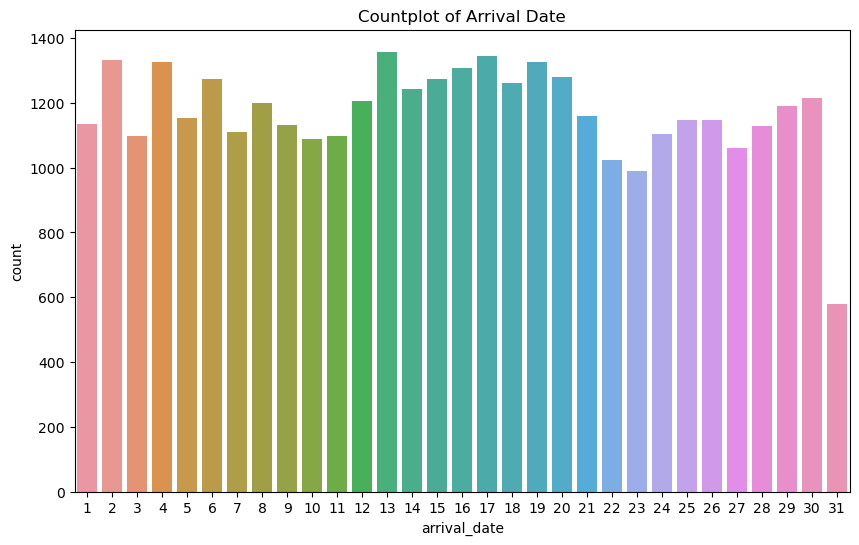

In [25]:
# arrival_date
plt.figure(figsize=(10, 6)) 
plt.title('Countplot of Arrival Date')
sns.countplot(data = df,x = 'arrival_date')

#### Insights:
- The chart above shows the bookings by arrival dates. There isn't abnormal value in this column as there is 31 possible values for dates. The date with least bookings is 31th, but considering that in some months there are only 30 days, the date with least bookings is in fact 23th. 
- Therefore, if monthly maintenance is needed to conduct, the 23th day of the month is a good choice as this will affect the least customers. 

<AxesSubplot:title={'center':'Countplot of Market Segment Type'}, xlabel='market', ylabel='count'>

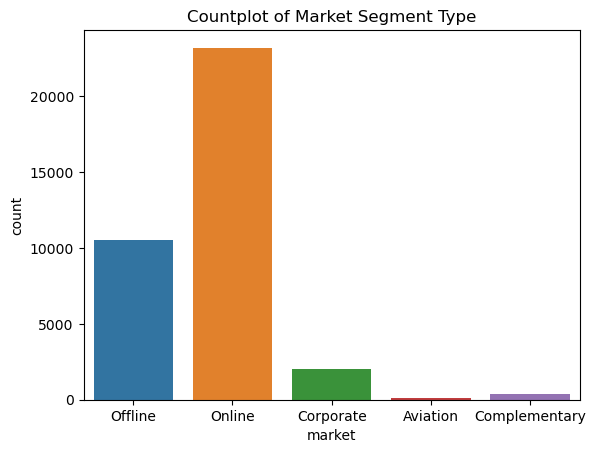

In [26]:
# market segment type
plt.title('Countplot of Market Segment Type')
sns.countplot(data = df,x = 'market')

#### Insights:
- Most reservations are from online, the second frequent is offline, and the third frequent is corporate market. The share of aviation and complementary is negligable.
- It is crucial that the hotel make a neat and clear official website that shows everything needed and attracts customers. Meanwhile, offline services like front desk and services need to be ensured as well. 

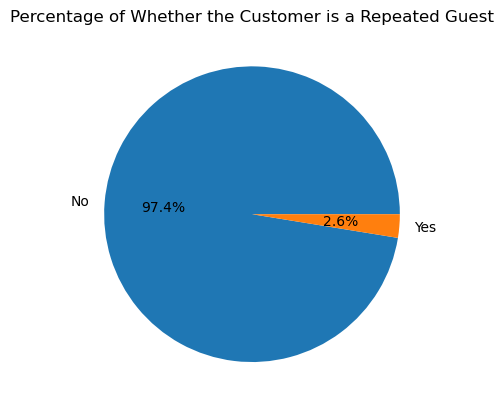

In [27]:
# whether the customer is a repeated guest
repeated_guest_pc = df['repeated_guest'].value_counts(normalize=True)*100
plt.pie(repeated_guest_pc, labels=['No','Yes'], autopct='%1.1f%%')
plt.title('Percentage of Whether the Customer is a Repeated Guest')
plt.show()

#### Insight:
- There isn't abnormal value in the column as it is binary and we only see two unique values.
- 97.4% of the guests are not repeated, so most guests are new to the hotel.
- That means it is necessary for the hotel to list detailed information of rooms and prices and also contact methods to the new customers in order to attract them, not expecting that they already knew something. First impression is important. 

<AxesSubplot:title={'center':'Countplot of Number of Previous Canceled Bookings'}, xlabel='prev_cancellations', ylabel='count'>

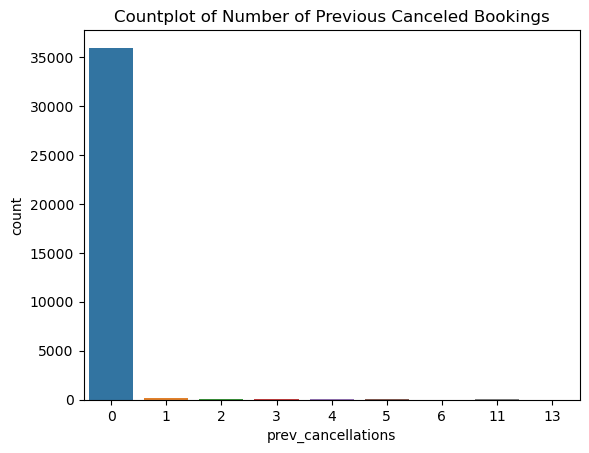

In [28]:
# Number of previous bookings that were canceled by the customer prior to the current booking
plt.title('Countplot of Number of Previous Canceled Bookings')
sns.countplot(data = df,x = 'prev_cancellations')

#### Insights:
- There isn't abnormal value in this column.
- The definite majority does not have previous cancelation records. There are very few customers have 1 to 13 previous cancellations.
- The result allies with the previous insight that most customers are new to the hotel. Also, it can mean that most people kept their bookings until the end. 
- Meanwhile, for those who have over 3 previous cancellations, I believe the hotel should track them specifically to see their patterns or if they have very particular concerns that influence their decisions.

<AxesSubplot:title={'center':'Countplot of Number of Previous Not-Canceled Bookings'}, xlabel='prev_bookings', ylabel='count'>

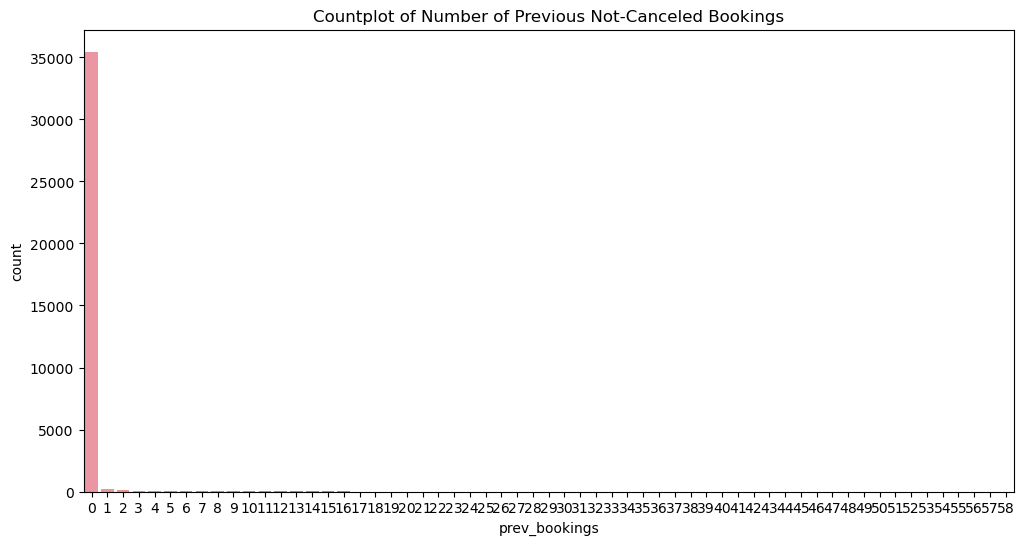

In [29]:
# Number of previous bookings not canceled by the customer prior to the current booking
plt.figure(figsize=(12, 6)) 
plt.title('Countplot of Number of Previous Not-Canceled Bookings')
sns.countplot(data = df,x = 'prev_bookings')

#### Insights:
- There isn't abnormal value in this column.
- The definite majority does not have previous booking records that are not canceled. There are very few customers have 1 to 58 previous bookings. 
- Together with the finding above, we confirm again that most customers are new to the hotel.
- For those who have over 3 previous not canceled bookings, they can be considered old clients that really like this hotel and be satisfied staying. The hotel can keep close connections with those clients, offering extra discounts/promotions in order to strengthen the reputation and impression. Then, apart from keeping them as customers, it is beneficial that they may recommend the hotel to others so that the hotel can attract new clients.

<AxesSubplot:title={'center':'Countplot of Number of Special Requests'}, xlabel='special_requests', ylabel='count'>

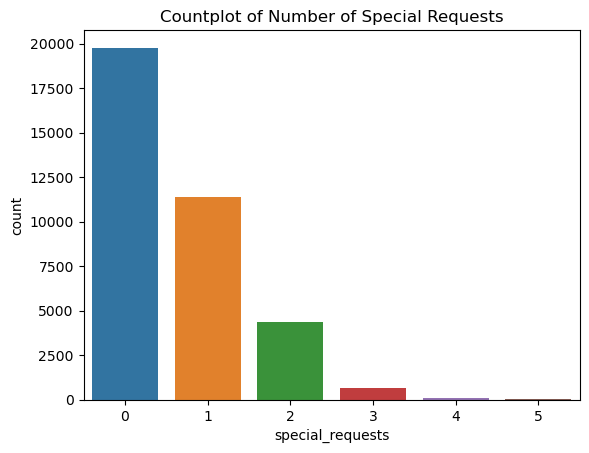

In [30]:
# Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
plt.title('Countplot of Number of Special Requests')
sns.countplot(data = df,x = 'special_requests')

#### Insights:
- Most people have no special requests and a fair number of customers have 1 to 2 special requests. Very few has 3 to 5.
- This indicates that most customers does not have a very high standard about the room; therefore it is easier for the hotel to accommodate them into different rooms when they come in together.
- For those who have 3-5 special requests, it is not that easy to meet especially when the rooms are about to be full. In this case, the hotel need to balance between those 'picky' clients and potentially more clients in number. It also depends on whether the 'picky' clients are also old customers who stay for many times.

### Also, we need to look at the columns of continuous data (lead_time & avg_price)

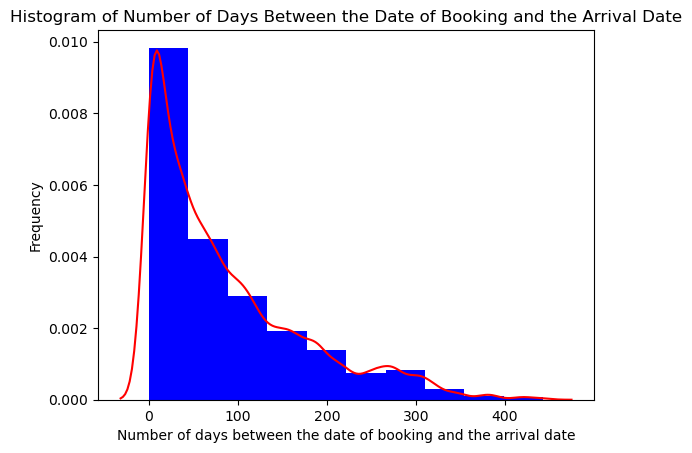

In [31]:
# Number of days between the date of booking and the arrival date (lead_time)
plt.hist(df['lead_time'], density=True,color='blue')
plt.title('Histogram of Number of Days Between the Date of Booking and the Arrival Date')
sns.kdeplot(df['lead_time'], color='red')
plt.xlabel('Number of days between the date of booking and the arrival date')
plt.ylabel('Frequency')
plt.show()

#### Insights:
- The distribution is highly right-skewed and there is no need to rule out outliers.
- Most of time ranges in between are from 0 to 200 days. It is rare that a customer make a reservation 200 days or more ahead.
- This indicates that most people tend to make reservations close to their arrival date. The hotel can properly raise prices a little bit when the customer try to make a 'near' reservation since he/she tend to be urgent, while considering competitions of other hotels.

In [32]:
# examine whether there is abnormal value in the column
print('The number of 0 in this column is: ',np.sum(df['avg_price'] == 0))
print('The number of negative value in the column is: ',len(df) - np.sum(df['avg_price'] >= 0))

The number of 0 in this column is:  545
The number of negative value in the column is:  0


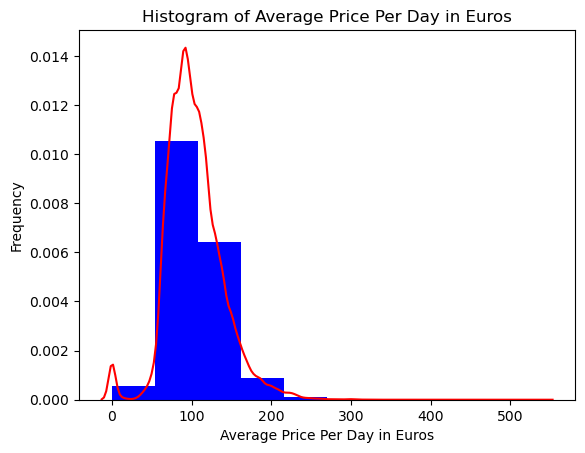

In [33]:
# Average price per day of the reservation in euros
plt.hist(df['avg_price'], density=True,color='blue')
plt.title('Histogram of Average Price Per Day in Euros')
sns.kdeplot(df['avg_price'], color='red')
plt.xlabel('Average Price Per Day in Euros')
plt.ylabel('Frequency')
plt.show()

#### Insights:
- There isn't abnormal value in this column (as there is no negative value; average price of 0 is possible for customers who use mileage plan or other promotions).
- This distribution seems to be normal. Most average prices are between 50 to 150 euros.
- We need to rule out outliers since it is right skewed. And the right tail is long. 

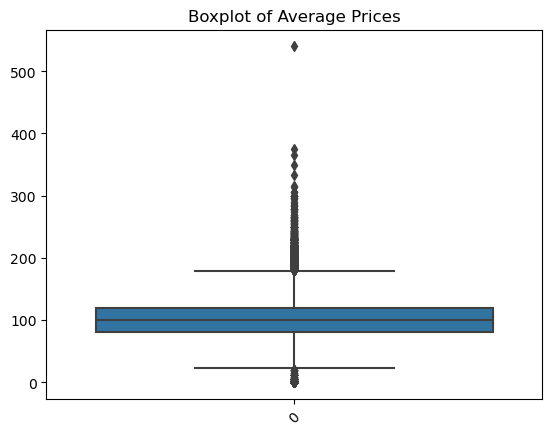

In [34]:
# Boxplot to visualiza distribution
sns.boxplot(data=df['avg_price'])
plt.xticks(rotation=45)
plt.title('Boxplot of Average Prices')
plt.show()

#### Explanation:
- To remove outliers, we use Interquartile Range(IQR) and therefore eliminate all data points above the upper line and below the lower line

In [35]:
# Interquartile Range (IQR) to identify outliers in average prices
Q1 = df['avg_price'].quantile(0.25)
Q3 = df['avg_price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers_iqr = df[((df['avg_price'] < lower_bound) | (df['avg_price'] > upper_bound))]
print("Outliers based on IQR:")
print(outliers_iqr)

Outliers based on IQR:
      Booking_ID  no_of_adults  no_of_children  weekend_nights  week_nights  \
60      INN00061             2               2               0            1   
63      INN00064             1               0               0            1   
114     INN00115             2               2               2            2   
127     INN00128             2               2               0            2   
145     INN00146             1               0               0            2   
...          ...           ...             ...             ...          ...   
36221   INN36222             2               2               2            4   
36227   INN36228             2               2               0            1   
36250   INN36251             1               0               0            2   
36263   INN36264             1               0               2            1   
36269   INN36270             2               2               0            1   

         meal_plan  parking 

In [36]:
# Drop outliers from the original DataFrame
df = df.drop(outliers_iqr.index)
df.shape

(34579, 25)

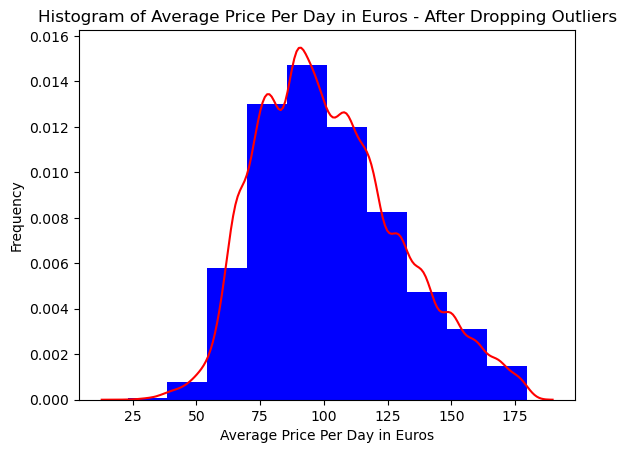

In [37]:
# plot the new histogram after dropping outliers
plt.hist(df['avg_price'], density=True,color='blue')
plt.title('Histogram of Average Price Per Day in Euros - After Dropping Outliers')
sns.kdeplot(df['avg_price'], color='red')
plt.xlabel('Average Price Per Day in Euros')
plt.ylabel('Frequency')
plt.show()

### Explanation:
- We can see that the distribution is normal and centered, not skewed anymore. Our dataset has been improved.

## Data Analysis

In [38]:
## Are the cancel rates for customers with different room types different statistically? 
room_ANOVA = ols('cancel ~ room', data=df).fit()
anova_table1 = sm.stats.anova_lm(room_ANOVA, typ=2)
print(anova_table1)

               sum_sq       df          F    PR(>F)
room         2.601821      1.0  11.744967  0.000611
Residual  7659.719183  34577.0        NaN       NaN


#### Insights:
- As shown in the table above, the p-value for room (room_type) variables is 0.0006, which is way less than 0.05.
- Therefore, we can conclude that the cancel rates for customers with different room types are statistically inconsistent (different), which is also evident based on the chart below.

<AxesSubplot:xlabel='booking_status', ylabel='count'>

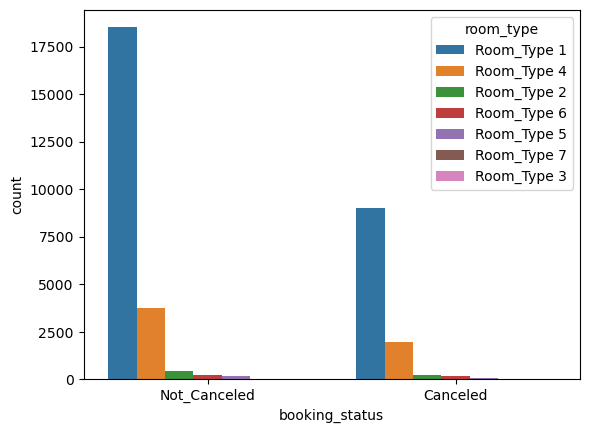

In [39]:
# cancel counts vs room_type
sns.countplot(data = df,x = 'booking_status',hue = 'room_type')

In [40]:
## Now, let's see whether the room type is correlated with booking status, and if so, the direction of such correlation
pearsonr_room, p_value_room = pearsonr(df['room'], df['cancel'])
print("Correlation coefficient between arrival month and booking status:", pearsonr_room)
print("P-value for the correlation:", p_value_room)

Correlation coefficient between arrival month and booking status: 0.01842716414103173
P-value for the correlation: 0.0006107895826922152


#### Insights:
- A Pearson's r of 0.0184 indicates that booking status is slightly positively correlated with room type, and p-value is 0.00061, which is less than 0.05, therefore we **WILL** use it as independent variable for our model.

In [41]:
## Do those who bring their children with them honor their reservation more than those who do not?
child_ANOVA = ols('cancel ~ no_of_children', data=df).fit()
anova_table2 = sm.stats.anova_lm(child_ANOVA, typ=2)
print(anova_table2)

                     sum_sq       df          F   PR(>F)
no_of_children     3.107487      1.0  14.028537  0.00018
Residual        7659.213518  34577.0        NaN      NaN


#### Insights:
- As shown in the table above, the p-value for children (no_of_children) variables is 0.00018, which is less than 0.05.
- Therefore, we can conclude that the cancel rates for customers who bring different numbers of children with them are statistically unconsistent (different).

In [42]:
## Now, let's see whether the no_of_children is correlated with booking status, and if so, the direction of such correlation
pearsonr_child, p_value_child = pearsonr(df['no_of_children'], df['cancel'])
print("Correlation coefficient between arrival month and booking status:", pearsonr_child)
print("P-value for the correlation:", p_value_child)

Correlation coefficient between arrival month and booking status: 0.02013837645782934
P-value for the correlation: 0.00018034924351939853


#### Insights: 
- A Pearson's r of 0.0201 indicates that booking status is slightly positively correlated with number of children, and the p-value is 0.00018, which is less than 0.05, therefore we **WILL** use it as independent variable for our model.

#### Meanwhile, we wonder whether simply categorizing customers into two groups based on whether they bring children with them (instead of based on the number of child they bring) would yield different results.

In [43]:
pearsonr_bring_child, p_value_bring_child = pearsonr(df['bring_child'], df['cancel'])
print("Correlation coefficient between arrival month and booking status:", pearsonr_bring_child)
print("P-value for the correlation:", p_value_bring_child)

Correlation coefficient between arrival month and booking status: 0.016839529179709226
P-value for the correlation: 0.001739207590382824


#### Insights:
-  A Pearson's r of 0.0168 indicates that booking status is slightly positively correlated with whether a customer brings child, and the p-value is less than 0.05, but it is greater than the p-value in cell 42, therefore we **WILL NOT** use it as independent variable for our model.

In [44]:
## Is there seasonality for cancel rate? (Whether cancel rate are inconsistent throughout a year) 
month_ANOVA = ols('cancel ~ arrival_month', data=df).fit()
anova_table3 = sm.stats.anova_lm(month_ANOVA, typ=2)
print(anova_table3)

                    sum_sq       df         F    PR(>F)
arrival_month     0.422800      1.0  1.908033  0.167191
Residual       7661.898204  34577.0       NaN       NaN


#### Insights:
- As shown in the table above, the p-value for month (arrival_month) variables is 0.167, which is greater than 0.05, therefore, we **cannot** conclude that the cancel rates for customers arrived in different months of a year are statistically inconsistent (different).

In [45]:
## Now, let's see whether the room type is correlated with booking status, and if so, the direction of such correlation
pearsonr_month, p_value_month = pearsonr(df['arrival_month'], df['cancel'])
print("Correlation coefficient between arrival month and booking status:", pearsonr_month)
print("P-value for the correlation:", p_value_month)

Correlation coefficient between arrival month and booking status: -0.007428262949628766
P-value for the correlation: 0.16719088006049282


#### Insights:
-  A Pearson's r of -0.0074 indicates that booking status is slightly negatively correlated with arrival months, and the p-value is 0.167, which is greater than 0.05, therefore, it **WILL NOT** be considered as an independent variable for our model.

#### Meanwhile, we wonder whether categorizing customers into 4 groups based on the season they arrived (spring,summer,fall,winter) would yield a more statistically significant result (a smaller p-value).

In [46]:
pearsonr_season, p_value_season = pearsonr(df['season'], df['cancel'])
print("Correlation coefficient between season and booking status:", pearsonr_season)
print("P-value for the correlation:", p_value_season)

Correlation coefficient between season and booking status: -0.12059438815763397
P-value for the correlation: 3.591943730311748e-112


#### Insights:
-  A Pearson's r of -0.1206 indicates that booking status is slightly negatively correlated with arrival season, and the p-value is 3.592*e-112, which is way less than 0.05, therefore, we **WILL** use season as an independent variable for our model instead of months.

### We also want to examine whether the cancel rates are influenced by the year.

In [47]:
## Is the cancel rate in 2017 different from 2018? 
cancel_rates_2017 = df[df['arrival_year'] == 2017]['cancel'].mean()
cancel_rates_2018 = df[df['arrival_year'] == 2018]['cancel'].mean()

# Perform t-test to check for significant difference
t_stat, p_value = ttest_ind(df[df['arrival_year'] == 2017]['cancel'], 
                            df[df['arrival_year'] == 2018]['cancel'])

# Print cancellation rates and p-value
print("Cancellation rate in 2017:", cancel_rates_2017)
print("Cancellation rate in 2018:", cancel_rates_2018)
print("P-value for the t-test:", p_value)

Cancellation rate in 2017: 0.15001627074520013
Cancellation rate in 2018: 0.3706608518271023
P-value for the t-test: 2.1786386495439303e-247


#### Insights:
-  Since p-value of the t-test is very small and much less than 0.05, so at significantce level 5%, we can reject the null hypothesis and conclude that cancel rate in 2017 is significantly different from that in 2018.

In [48]:
# check correlation with cancel status
pearsonr_year, p_value_year = pearsonr(df['arrival_year'], df['cancel'])
print("Correlation coefficient between arrival year and booking status:", pearsonr_year)
print("P-value for the correlation:", p_value_year)

Correlation coefficient between arrival year and booking status: 0.17919030157570098
P-value for the correlation: 2.178638649717232e-247


#### Insights:
- A Pearson's r of 0.179 indicates that booking status is slightly positively correlated with arrival year. P-value being less than 0.05 indicates that this correlation between year and cancel status is significant at 5% level.

### Generally check whether the independent variables are correlated with dependent variables:

In [49]:
# Define independent variables (features) and dependent variable (outcome)
X = df[['no_of_adults','no_of_children','weekend_nights','week_nights','meal','parking','room','lead_time','arrival_year','arrival_month','arrival_date','mkt','repeated_guest','prev_cancellations','prev_bookings','avg_price','special_requests']]
y = df['cancel'] 

# Calculate pearsonr correlation coefficient for each independent variable
correlation_coefficients = []
for col in X.columns:
    corr_coef, p_value = pearsonr(X[col], y)
    correlation_coefficients.append((col, corr_coef, p_value))
correlation_df = pd.DataFrame(correlation_coefficients, columns=['Independent Variable', 'Correlation Coefficient', 'P-value'])
print(correlation_df)

   Independent Variable  Correlation Coefficient        P-value
0          no_of_adults                 0.080543   7.206377e-51
1        no_of_children                 0.020138   1.803492e-04
2        weekend_nights                 0.054285   5.437441e-24
3           week_nights                 0.082085   9.022263e-53
4                  meal                 0.047471   1.027408e-18
5               parking                -0.084108   2.524262e-55
6                  room                 0.018427   6.107896e-04
7             lead_time                 0.440703   0.000000e+00
8          arrival_year                 0.179190  2.178639e-247
9         arrival_month                -0.007428   1.671909e-01
10         arrival_date                 0.009275   8.459203e-02
11                  mkt                -0.013115   1.473232e-02
12       repeated_guest                -0.101599   5.236608e-80
13   prev_cancellations                -0.031149   6.893062e-09
14        prev_bookings                -

#### Insights:
- As suggested from the table above, all our independent variables except for arrival_month and arrival_date have significant correlations with our dependent variable since p-values are smaller than 5%. 
- The top three strongly correlated factors are Number of days between the date of booking and the arrival date (lead_time), Total number of special requests made by the customer(special_requests), and Year of arrival date(arrival_year).

## Modeling

As stated above, we will use all our independent variables except for arrival_month and arrival_date to do the logsitic regression model.

In [50]:
## select predictors
X_logistic = df[['no_of_children','no_of_adults','weekend_nights','week_nights','meal','parking','lead_time','arrival_year','season','mkt','repeated_guest','prev_cancellations','prev_bookings','avg_price','special_requests']]

Check assumptions of logistic regression:

1. Binary Outcome: The outcome variable(cancel) is binary, 1 for canceled, 0 for not.
2. Independence of Observations: Each observation(row) is a unique booking.
3. Large Sample Size: Our dataset has 36275 rows of data.
4. No Outliers: We checked outliers at the beginning of the project.

Check no multicolinearity between independent variables:

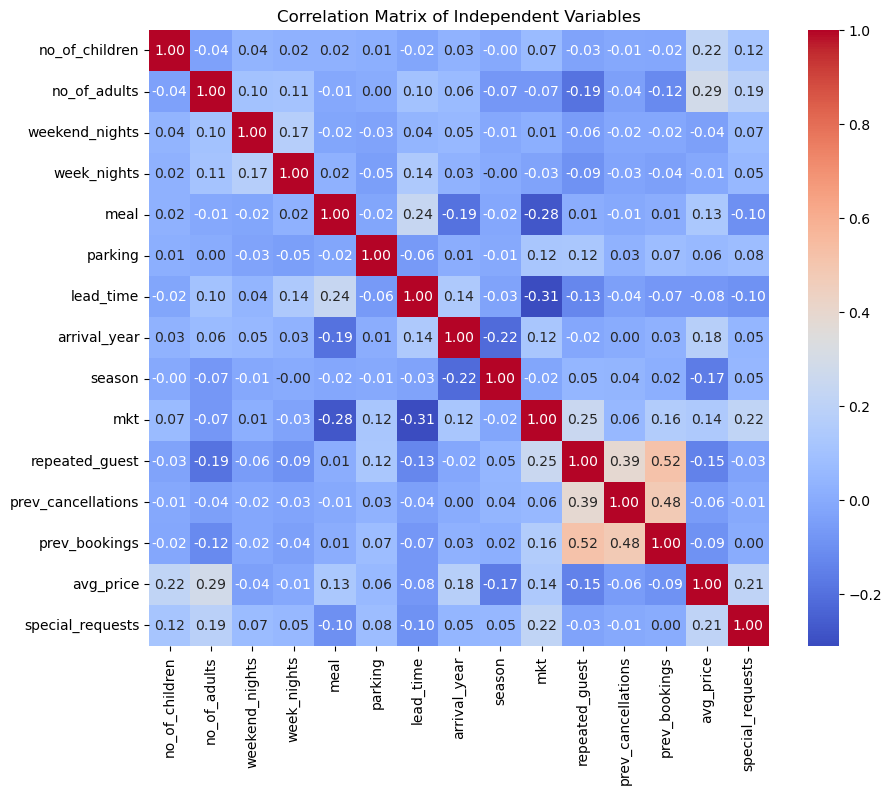

In [51]:
# Calculate correlation matrix
correlation_matrix = X_logistic.corr()

# Plot correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Independent Variables')
plt.show()

#### Insights:
- There are no high correlations between independent variables. The highest is 0.52, which is considerable.
- As a result, there is no multicolinearity between our independent variables for the regression.

In [53]:
# logistic regression to predict final decisions (cancel or not)
# train-test split to avoid overfitting
X_train, X_test, y_train, y_test = train_test_split(X_logistic, y, test_size=0.2)

# fit the Model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

coefficients = model.coef_[0]
intercept = model.intercept_
coefficients_df = pd.DataFrame({'Feature': X_logistic.columns, 'Coefficient': coefficients})
print("Intercept:", intercept)
print("\nCoefficients:")
print(coefficients_df)

Accuracy: 0.7938114517061885
Intercept: [-0.00025578]

Coefficients:
               Feature  Coefficient
0       no_of_children     0.047949
1         no_of_adults     0.165787
2       weekend_nights     0.202855
3          week_nights     0.019408
4                 meal    -0.547164
5              parking    -0.224512
6            lead_time     0.015275
7         arrival_year    -0.001949
8               season    -0.209103
9                  mkt     0.889390
10      repeated_guest    -0.094903
11  prev_cancellations    -0.013946
12       prev_bookings    -0.282179
13           avg_price     0.021595
14    special_requests    -1.265707


d:\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### Insights:
- The accurancy of our logistic regression is 79.38%, which is quite good. That means our predictors can well predict the customers' final decisions.
- Categorical data that are neither binary nor in order cannot be interpreted. (for meal type, arrival year, season, market segment type)
- Generally:
- - Number of children, number of adults, number of weekend nights, number of week nights, number of days between the day of booking and the arrival datee, and average price per day have a positive relationship with the possibility of cancelation.
- - Requiring parking space, being a repeated guest, number of previous cancelations, number of previous bookings that are not canceled, and number of special requests have a negative relationship with the possibility of cancelation.

- Practically:
- - For longer stay or a larger group of travellers, people tend to cancel. This indicates that the hotel is better for short stay and few guests. The hotel can improve its experience provided for long stay or large groups.
- - The result that more days between the day of booking and the arrival date, more likely to cancel is normal, since longer time ranges in between allows for more randomness and changes of plans.
- - Higher price resulting in higher probability to cancel is easy to understand. Most people tend to cheaper choices.
- - Requiring parking space and number of special requests are both requests to the hotel. Once customers have requests, they are highly possible to honor the reservation as they have make up their mind and start to discuss details. This result is clear to see.
- - Being a repeated guest, number of previous cancelations, and number of previous bookings all refer to whether the customer is a repeated client. These factors having a negative relationship with cancelation possibility suggests that the hotel has provided the repeated customers with satisfactory experience before. That is a good aspect of the hotel that it need to keep.